In [1]:
import warnings
warnings.filterwarnings('ignore')
import scanorama
import anndata
import scanpy as sc
import seaborn as sns
%matplotlib inline
import scipy.sparse as ss
import pandas as pd
import numpy as np
# import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pathlib

/home/wtian/local/anaconda3/envs/cemba-mapping/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Human

In [2]:
sp='Human'

In [3]:
cell_type_meta = pd.read_csv(f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/integration_results/cytosplore.{sp.lower()}.tsv',sep='\t')
DNAm_meta = cell_type_meta[['DNAm_cluster_name','DNAm_cluster_label','DNAm_cluster_color']].drop_duplicates()


cfms = []

### human exc

In [4]:
rna_mt = 'Glutamatergic'
snmc_mt = 'Exc'
mc = 'CHN'
rnapath = f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.processed.h5ad'
snmcpath = f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{snmc_mt}.{mc}.h5ad'
rna_marker_list = [
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.cluster_marker.msg',
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.subclass_marker.msg']
snmc_marker_list = [
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{mc}.{snmc_mt}.MajorCluster_marker.msg',
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{mc}.{snmc_mt}.SubCluster_marker.msg']

rna_markers = pd.concat([pd.read_msgpack(fn) for fn in rna_marker_list])['names']
snmc_markers = pd.concat([pd.read_msgpack(fn) for fn in snmc_marker_list])['names']


rna_adata = anndata.read_h5ad(rnapath)
rna_adata.var.reset_index(inplace=True)
rna_adata.var.set_index('Ensembl_ID',inplace=True)
rna_adata.var.rename(columns={'index':'gene'},inplace=True)


snmc_adata = anndata.read_h5ad(snmcpath)
snmc_adata.X = snmc_adata.X.max()-snmc_adata.X
sc.pp.scale(snmc_adata)



rna_markers = rna_markers.apply(
    lambda x: rna_adata.var[rna_adata.var['gene']==x].index.values[0])
markers = pd.Index(set(rna_markers.to_list()+snmc_markers.to_list()))
# markers = pd.Index(set(snmc_markers.to_list()))
markers = markers[markers.isin(snmc_adata.var.index) & markers.isin(rna_adata.var.index)]



rna_adata = rna_adata[:, markers]
snmc_adata = snmc_adata[:, markers]




results = scanorama.correct( [rna_adata.X, snmc_adata.X], 
                            [rna_adata.var_names.values, snmc_adata.var_names.values])

(_rna, _mc_gene), genes = results






int_rna_adata = anndata.AnnData(X=_rna, obs=rna_adata.obs, var=rna_adata.var.loc[genes])
int_snmc_adata = anndata.AnnData(X=_mc_gene, obs=snmc_adata.obs, var=snmc_adata.var.loc[genes])
int_rna_adata.obs['DataType'] = 'rna'
int_snmc_adata.obs['DataType'] = 'snmc'



int_adata = int_rna_adata.concatenate(int_snmc_adata, join="inner")
int_adata = int_adata[int_adata.obs['SubCluster']!='Outlier']


sc.tl.pca(int_adata)
# sc.pl.pca(int_adata, color='DataType')
sc.pp.neighbors(int_adata, n_neighbors=30)
sc.tl.umap(int_adata)



int_snmc_adata = int_adata[ int_adata.obs['DataType']=='snmc' ]
int_rna_adata = int_adata[ int_adata.obs['DataType']=='rna' ]


snmc_cell_counts = int_snmc_adata.obs['SubCluster'].value_counts()
rna_cell_counts = int_rna_adata.obs['cluster'].value_counts()



from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9).fit(int_snmc_adata.obsm['X_pca'], int_snmc_adata.obs['SubCluster'])
mapto = knn.predict(int_rna_adata.obsm['X_pca'])
tomap = int_rna_adata.obs[['cluster']]
tomap['mapto'] = mapto
dist, _ = knn.kneighbors(int_rna_adata.obsm['X_pca'])
tomap['dist_median'] = np.median(dist,axis=1)
tomap_num = tomap.groupby('cluster')['mapto'].value_counts().unstack()
tomap_dist = tomap.groupby(['cluster','mapto'])['dist_median'].mean().unstack()

def _most_mapping(row):
    top2 = row[pd.Series.argsort(row)][-1:-3:-1]
    
    keep = top2>0.5*top2[0]
    index = top2.index.to_numpy()
    index[~keep] = np.NaN
    return pd.Series(index)
def _closest_mapping(row,):
    if np.all(~row.isna()):
        dist = tomap_dist.loc[row.name, [row[0], row[1]]]
        if dist[0]>2*dist[1]:
            row[0] = np.NaN
        elif dist[1]>2*dist[0]:
            row[1] = np.NaN
    return row
    
mapping = tomap_num.fillna(0).apply(_most_mapping, axis=1).apply(_closest_mapping, axis=1)
mapping['num'] = tomap_num.apply(np.nansum, axis=1).astype(int)
# mapping.to_csv(f'integration_results/{sp}_{snmc_mt}_rna2snmc_knn.csv')   



from cemba_data.tools.integration.utilities import calculate_direct_confusion
from cemba_data.plot.clustering import plot_confusion_matrix, auto_order





rightpart = pd.DataFrame(int_rna_adata.obs['cluster'])
rightpart['mapto'] = mapto
leftpart = pd.DataFrame(int_snmc_adata.obs['SubCluster'])
leftpart['mapto'] = int_snmc_adata.obs['SubCluster']
cfm=calculate_direct_confusion(leftpart, rightpart)

DNAm_rename = dict(zip(DNAm_meta['DNAm_cluster_name'], DNAm_meta['DNAm_cluster_label']))
cfm.index.name = 'DNAm Cluster'
cfm.columns.name = 'RNA Cluster'
cfm.index = cfm.index.map(lambda x: f'{DNAm_rename[x]} ({snmc_cell_counts[x]})')
cfm.columns = cfm.columns.map(lambda x:f'{x} ({rna_cell_counts[x]})')

cfms.append(cfm)#############

Found 443 genes among all datasets
[[0.         0.87522604]
 [0.         0.        ]]
Processing datasets (0, 1)


### human inh

In [5]:
rna_mt = 'GABAergic'
snmc_mt = 'Inh'
mc = 'CHN'
rnapath = f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.processed.h5ad'
snmcpath = f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{snmc_mt}.{mc}.h5ad'
rna_marker_list = [
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.cluster_marker.msg',
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.subclass_marker.msg']
snmc_marker_list = [
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{mc}.{snmc_mt}.MajorCluster_marker.msg',
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{mc}.{snmc_mt}.SubCluster_marker.msg']


rna_markers = pd.concat([pd.read_msgpack(fn) for fn in rna_marker_list])['names']
snmc_markers = pd.concat([pd.read_msgpack(fn) for fn in snmc_marker_list])['names']


rna_adata = anndata.read_h5ad(rnapath)
rna_adata.var.reset_index(inplace=True)
rna_adata.var.set_index('Ensembl_ID',inplace=True)
rna_adata.var.rename(columns={'index':'gene'},inplace=True)


snmc_adata = anndata.read_h5ad(snmcpath)
snmc_adata.X = snmc_adata.X.max()-snmc_adata.X
sc.pp.scale(snmc_adata)



rna_markers = rna_markers.apply(
    lambda x: rna_adata.var[rna_adata.var['gene']==x].index.values[0])
markers = pd.Index(set(rna_markers.to_list()+snmc_markers.to_list()))
# markers = pd.Index(set(snmc_markers.to_list()))
markers = markers[markers.isin(snmc_adata.var.index) & markers.isin(rna_adata.var.index)]



rna_adata = rna_adata[:, markers]
snmc_adata = snmc_adata[:, markers]




results = scanorama.correct( [rna_adata.X, snmc_adata.X], 
                            [rna_adata.var_names.values, snmc_adata.var_names.values])

(_rna, _mc_gene), genes = results




int_rna_adata = anndata.AnnData(X=_rna, obs=rna_adata.obs, var=rna_adata.var.loc[genes])
int_snmc_adata = anndata.AnnData(X=_mc_gene, obs=snmc_adata.obs, var=snmc_adata.var.loc[genes])
int_rna_adata.obs['DataType'] = 'rna'
int_snmc_adata.obs['DataType'] = 'snmc'



int_adata = int_rna_adata.concatenate(int_snmc_adata, join="inner")
int_adata = int_adata[int_adata.obs['SubCluster']!='Outlier']


sc.tl.pca(int_adata)
# sc.pl.pca(int_adata, color='DataType')
sc.pp.neighbors(int_adata, n_neighbors=30)
sc.tl.umap(int_adata)



int_snmc_adata = int_adata[ int_adata.obs['DataType']=='snmc' ]
int_rna_adata = int_adata[ int_adata.obs['DataType']=='rna' ]


snmc_cell_counts = int_snmc_adata.obs['SubCluster'].value_counts()
rna_cell_counts = int_rna_adata.obs['cluster'].value_counts()



from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9).fit(int_snmc_adata.obsm['X_pca'], int_snmc_adata.obs['SubCluster'])
mapto = knn.predict(int_rna_adata.obsm['X_pca'])
tomap = int_rna_adata.obs[['cluster']]
tomap['mapto'] = mapto
dist, _ = knn.kneighbors(int_rna_adata.obsm['X_pca'])
tomap['dist_median'] = np.median(dist,axis=1)
tomap_num = tomap.groupby('cluster')['mapto'].value_counts().unstack()
tomap_dist = tomap.groupby(['cluster','mapto'])['dist_median'].mean().unstack()
    
mapping = tomap_num.fillna(0).apply(_most_mapping, axis=1).apply(_closest_mapping, axis=1)
mapping['num'] = tomap_num.apply(np.nansum, axis=1).astype(int)
# mapping.to_csv(f'integration_results/{sp}_{snmc_mt}_rna2snmc_knn.csv')   



rightpart = pd.DataFrame(int_rna_adata.obs['cluster'])
rightpart['mapto'] = mapto
leftpart = pd.DataFrame(int_snmc_adata.obs['SubCluster'])
leftpart['mapto'] = int_snmc_adata.obs['SubCluster']
cfm=calculate_direct_confusion(leftpart, rightpart)

DNAm_rename = dict(zip(DNAm_meta['DNAm_cluster_name'], DNAm_meta['DNAm_cluster_label']))
cfm.index.name = 'DNAm Cluster'
cfm.columns.name = 'RNA Cluster'
cfm.index = cfm.index.map(lambda x: f'{DNAm_rename[x]} ({snmc_cell_counts[x]})')
cfm.columns = cfm.columns.map(lambda x:f'{x} ({rna_cell_counts[x]})')


cfms.append(cfm)#############

Found 541 genes among all datasets
[[0.         0.88251218]
 [0.         0.        ]]
Processing datasets (0, 1)


### human nonn

In [6]:
rna_mt = 'Non-Neuronal'
snmc_mt = 'NonN'
mc = 'CGN'
rnapath = f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.processed.h5ad'
snmcpath = f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{snmc_mt}.{mc}.h5ad'
rna_marker_list = [
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.cluster_marker.msg',
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.rna.{rna_mt}.subclass_marker.msg']
snmc_marker_list = [
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{mc}.{snmc_mt}.MajorCluster_marker.msg',
    f'PATH-TO-ANALYSIS/{sp}/integration-with-rna/{sp}.snmc.{mc}.{snmc_mt}.SubCluster_marker.msg']


rna_markers = pd.concat([pd.read_msgpack(fn) for fn in rna_marker_list])['names']
snmc_markers = pd.concat([pd.read_msgpack(fn) for fn in snmc_marker_list])['names']


rna_adata = anndata.read_h5ad(rnapath)
rna_adata.var.reset_index(inplace=True)
rna_adata.var.set_index('Ensembl_ID',inplace=True)
rna_adata.var.rename(columns={'index':'gene'},inplace=True)


snmc_adata = anndata.read_h5ad(snmcpath)
snmc_adata.X = snmc_adata.X.max()-snmc_adata.X
sc.pp.scale(snmc_adata)



rna_markers = rna_markers.apply(
    lambda x: rna_adata.var[rna_adata.var['gene']==x].index.values[0])
markers = pd.Index(set(rna_markers.to_list()+snmc_markers.to_list()))
# markers = pd.Index(set(snmc_markers.to_list()))
markers = markers[markers.isin(snmc_adata.var.index) & markers.isin(rna_adata.var.index)]



rna_adata = rna_adata[:, markers]
snmc_adata = snmc_adata[:, markers]

rna_adata = rna_adata[:, ~np.any( np.isnan(rna_adata.X), axis=0)]


results = scanorama.correct( [rna_adata.X, snmc_adata.X], 
                            [rna_adata.var_names.values, snmc_adata.var_names.values])

(_rna, _mc_gene), genes = results




int_rna_adata = anndata.AnnData(X=_rna, obs=rna_adata.obs, var=rna_adata.var.loc[genes])
int_snmc_adata = anndata.AnnData(X=_mc_gene, obs=snmc_adata.obs, var=snmc_adata.var.loc[genes])
int_rna_adata.obs['DataType'] = 'rna'
int_snmc_adata.obs['DataType'] = 'snmc'



int_adata = int_rna_adata.concatenate(int_snmc_adata, join="inner")
int_adata = int_adata[int_adata.obs['SubCluster']!='Outlier']


sc.tl.pca(int_adata)
# sc.pl.pca(int_adata, color='DataType')
sc.pp.neighbors(int_adata, n_neighbors=30)
sc.tl.umap(int_adata)



int_snmc_adata = int_adata[ int_adata.obs['DataType']=='snmc' ]
int_rna_adata = int_adata[ int_adata.obs['DataType']=='rna' ]


snmc_cell_counts = int_snmc_adata.obs['SubCluster'].value_counts()
rna_cell_counts = int_rna_adata.obs['cluster'].value_counts()



from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9).fit(int_snmc_adata.obsm['X_pca'], int_snmc_adata.obs['SubCluster'])
mapto = knn.predict(int_rna_adata.obsm['X_pca'])
tomap = int_rna_adata.obs[['cluster']]
tomap['mapto'] = mapto
dist, _ = knn.kneighbors(int_rna_adata.obsm['X_pca'])
tomap['dist_median'] = np.median(dist,axis=1)
tomap_num = tomap.groupby('cluster')['mapto'].value_counts().unstack()
tomap_dist = tomap.groupby(['cluster','mapto'])['dist_median'].mean().unstack()
    
mapping = tomap_num.fillna(0).apply(_most_mapping, axis=1).apply(_closest_mapping, axis=1)
mapping['num'] = tomap_num.apply(np.nansum, axis=1).astype(int)
# mapping.to_csv(f'integration_results/{sp}_{snmc_mt}_rna2snmc_knn.csv')   



rightpart = pd.DataFrame(int_rna_adata.obs['cluster'])
rightpart['mapto'] = mapto
leftpart = pd.DataFrame(int_snmc_adata.obs['SubCluster'])
leftpart['mapto'] = int_snmc_adata.obs['SubCluster']
cfm=calculate_direct_confusion(leftpart, rightpart)

DNAm_rename = dict(zip(DNAm_meta['DNAm_cluster_name'], DNAm_meta['DNAm_cluster_label']))
cfm.index.name = 'DNAm Cluster'
cfm.columns.name = 'RNA Cluster'
cfm.index = cfm.index.map(lambda x: f'{DNAm_rename[x]} ({snmc_cell_counts[x]})')
cfm.columns = cfm.columns.map(lambda x:f'{x} ({rna_cell_counts[x]})')

cfms.append(cfm)#############


Found 249 genes among all datasets
[[0.         0.75995316]
 [0.         0.        ]]
Processing datasets (0, 1)


### human plot all

In [7]:
cfms = pd.concat(cfms).fillna(0)

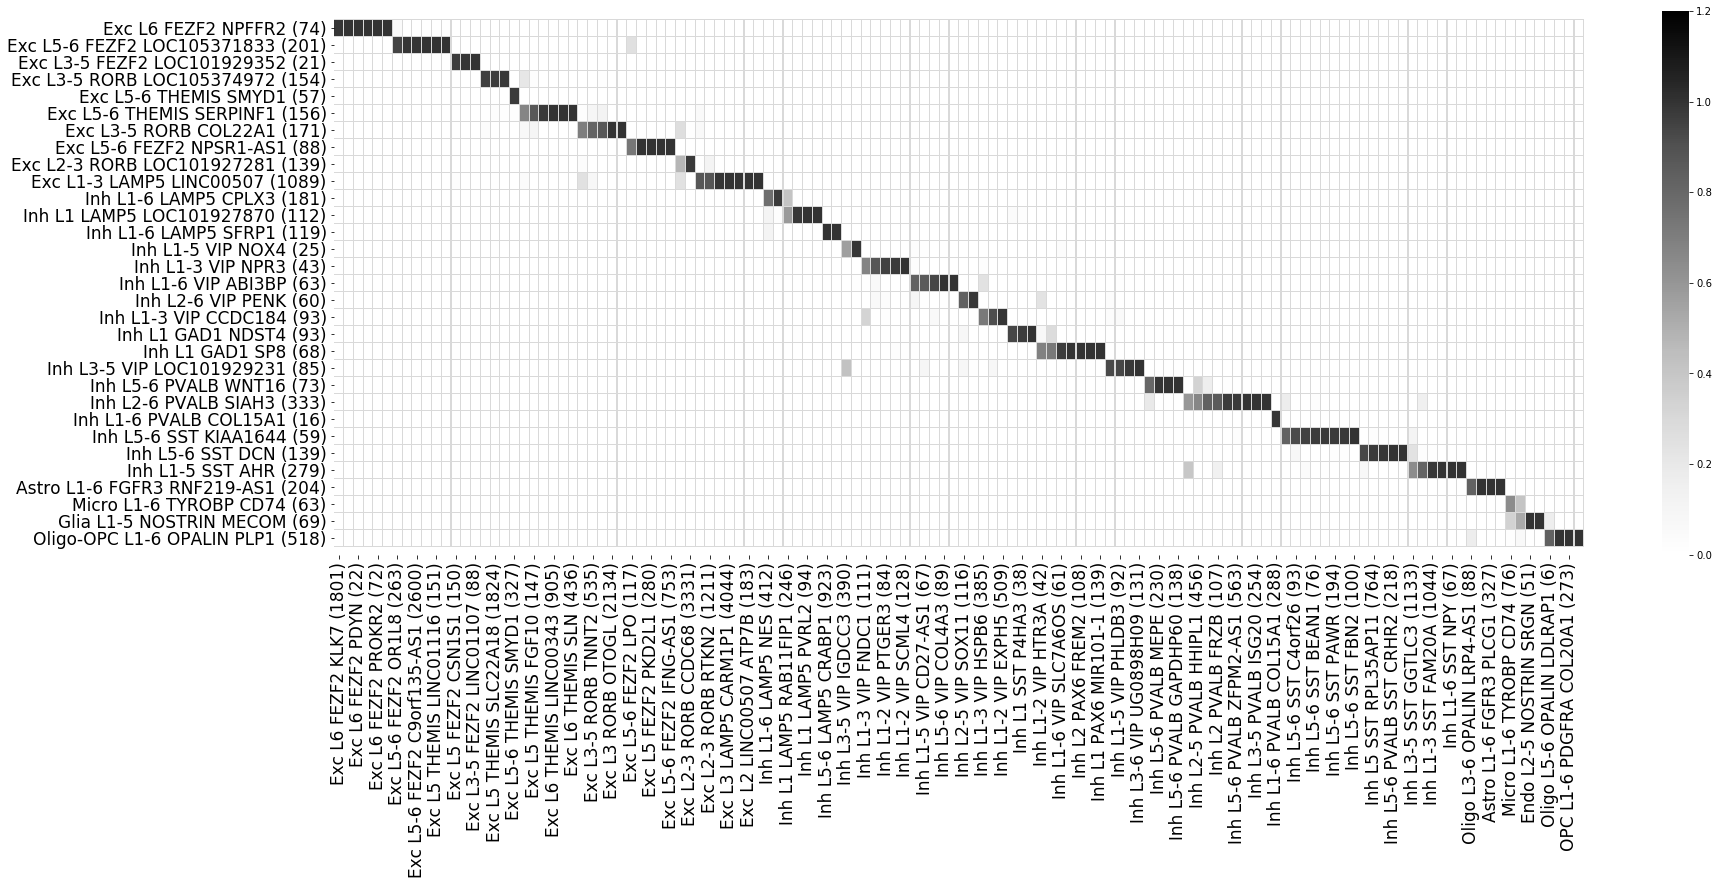

In [8]:
plt.figure(figsize=(28,10))
plot_confusion_matrix(cfms, plt.gca(), cfms.index, cmap='Greys', vmin=0, vmax=1.2, linewidth=0.1, linecolor='#d9d9d9')
# plt.gca().set_aspect(2)
plt.gca().tick_params(labelsize=17)
plt.xlabel('', fontsize=22)
plt.ylabel('', fontsize=22)
plt.show()
